# Predicting Mortgage Delinquency Risk

**Note: this is a new exercise, so if you find something weird, please bring it to my attention.**

You have been hired by a mortgage servicing firm (a company that buys mortgages and then collects mortgage payments from homeowners) to build a model to answer the question: 

**Given all available information about a newly issued mortgage, what is the likelihood that the mortgage will enter delinquency (the homeowner will be at least 30 days late on a mortgage payment) during the first two years of the mortgage?**

The servicer's hope, obviously, is to differentiate between mortgages to try and purchase (those that will be consistently paid) and mortgages they wish to avoid.

For this task, you have been given [REAL data on a sample of all US Standard single family home mortgages purchased or insured by Freddie Mac](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset) in a single calendar year along with payment data from that and two subsequent years.


## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_passive_prediction.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex2_merge_type",
    "ex4_num_mortgages",
    "ex5_num_obs",
    "ex7_num_mortgages",
    "ex7_share_delinquent",
    "ex10_num_obs",
    "ex12_roc_auc",
    "ex14_false_negative_rate",
    "ex16_num_obs",
    "ex16_share_delinquent",
    "ex17_false_negative_rate",
}
```


### Submission Limits

Please remember that you are **only allowed FOUR submissions to the autograder.** Your last submission (if you submit 4 or fewer times), or your third submission (if you submit more than 4 times) will determine your grade Submissions that error out will **not** count against this total.

That's one more than usual in case there are issues with exercise clarity.

## Data Cleaning and Organization

Data for this exercise can be [found here](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2004). This folder includes both the data to be used and documentation, though you can find [supplemental documentation here](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset).

The only difference between this data and the original Freddie Mac sampled data is that I've limited the scope of service data to three calendar years.

In [86]:
import warnings

warnings.filterwarnings("ignore")

results = {}

### Exercise 1

Begin by loading both: 

- the mortgage origination file (`sample_orig_2004.txt`). This *should* contain information on all mortgages issued in 2004, along with non-time varying features of these mortgages (the initial amount, the credit score of the applicant, etc.), and 
- the servicing data (`sample_svcg_2004orig_3years.txt`). This contains monthly records of all recorded payments (or non-payments) for all mortgages issued in 2004 during the calendar years of 2004, 2005, and 2006.

So the autograder can see the data, be sure to load it directly from a URL (don't download and load from your own system).

Load the data AND ensure your data has column names. You will likely need to reference the documentation to figure out how to do so.

In [87]:
import pandas as pd

origination_url = 'https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/mortgages/2004/sample_orig_2004.txt'
servicing_url = 'https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/mortgages/2004/sample_svcg_2004orig_3years.txt'

origination_columns = [ 'credit_score', 'first_payment_date','first_time_buyer', 'maturity_date', 'msa', 'mi_percent', 
                        'num_of_units', 'occupancy_status', 'original_cltv', 'original_dti_ratio', 'original_upb', 
                        'original_ltv', 'original_interest_rt', 'channel', 'ppm_flag', 'amortization_type', 
                        'property_state', 'property_type', 'postal_code', 'loan_seq_num', 'loan_purpose', 
                        'original_loan_term', 'num_borrowers', 'seller_name', 'service_name', 'super_conforming', 
                        'prr_loan_seq_num', 'program_indicator', 'rr_indicator', 'prop_val_method', 'io_indicator', 
                        'mi_cancel_indicator']

servicing_columns = ['loan_seq_num', 'monthly_rep_per', 'current_actual_upb', 'current_delinq_status', 'loan_age', 
                     'month_to_maturity', 'defect_settle_date', 'mod_flag', 'zero_bal_code','zero_bal_eff_data', 
                     'curr_int_rate', 'curr_non_int_bearing_upb', 'ddlpi', 'mi_recoveries', 'net_sale_proceeds', 
                     'non_mi_recoveries', 'total_exp', 'legal_costs', 'maint_preserve_costs', 'taxes_insurance', 
                     'misc_exp', 'actual_loss_cal', 'cum_mod_cost', 'step_mod', 'payment_deferral', 'eltv', 
                     'zero_bal_rem_upb', 'delinq_acuired_int', 'disaster_delinq', 'borrower_assist_status', 
                     'curr_month_mod_cost', 'int_bearing_upb']

In [88]:
"""Loading the datasets"""
origination_data = pd.read_csv(origination_url, sep="|", names=origination_columns)

servicing_data = pd.read_csv(servicing_url, sep="|", names=servicing_columns)

print(origination_data.head())

   credit_score  first_payment_date first_time_buyer  maturity_date      msa  \
0           701              200403                N         203402  45060.0   
1           648              200403                N         202402      NaN   
2           653              200403                Y         203402  20740.0   
3           747              200403                N         203402  30700.0   
4           731              200403                N         201902      NaN   

   mi_percent  num_of_units occupancy_status  original_cltv  \
0          25             1                P             90   
1           0             1                P             80   
2          17             1                P             87   
3           0             2                I             70   
4           0             1                P             80   

   original_dti_ratio  ...  num_borrowers                         seller_name  \
0                  43  ...              2                  

In [89]:
print(servicing_data.head())

   loan_seq_num  monthly_rep_per  current_actual_upb current_delinq_status  \
0  F04Q10000027           200402            101000.0                     0   
1  F04Q10000027           200403            101000.0                     0   
2  F04Q10000027           200404            101000.0                     0   
3  F04Q10000027           200405            101000.0                     0   
4  F04Q10000027           200406            100000.0                     0   

   loan_age  month_to_maturity  defect_settle_date mod_flag  zero_bal_code  \
0         0                360                 NaN      NaN            NaN   
1         1                359                 NaN      NaN            NaN   
2         2                358                 NaN      NaN            NaN   
3         3                357                 NaN      NaN            NaN   
4         4                356                 NaN      NaN            NaN   

   zero_bal_eff_data  ...  cum_mod_cost  step_mod  payment_def

### Exercise 2

What is the unit of observation in `sample_orig_2004.txt` and in `sample_svcg_2004orig_3years.txt`?

**ANSWER**

* 1. In the **origination data file (`sample_orig_2004.txt`)** each row represents a unique mortgage loan at the time of origination. Therefore the unit observation is a loan.
* 2. The **servicing data file (`sample_svcg_2004orig_3years.txt`)** includes servicing data on the unit of observation mention in the previous paragraph. So it is a monthly record of a mortgage loan's payment status. Each row in this dataset represents specific information for a specific loan.

### Exercise 3

Merge your two datasets. Be sure to use the `validate` keyword argument in `merge`.

Assuming that you list the data associated with `sample_orig_2004.txt` first and `sample_svcg_2004orig_3years.txt` second, what keyword are you passing to `validate`? Store your answer as a string (use one of: `"1:1"`, `"m:1"`, `"1:m"`, `"m:m"`) in a dictionary called `results` under the key `ex2_merge_type`.

In [90]:
"""merging data as per instruction"""
merged_data = origination_data.merge(servicing_data, on='loan_seq_num', validate='1:m')

results = {'ex2_merge_type': '1:m'}

In [91]:
print(merged_data.head())

   credit_score  first_payment_date first_time_buyer  maturity_date      msa  \
0           701              200403                N         203402  45060.0   
1           701              200403                N         203402  45060.0   
2           701              200403                N         203402  45060.0   
3           701              200403                N         203402  45060.0   
4           701              200403                N         203402  45060.0   

   mi_percent  num_of_units occupancy_status  original_cltv  \
0          25             1                P             90   
1          25             1                P             90   
2          25             1                P             90   
3          25             1                P             90   
4          25             1                P             90   

   original_dti_ratio  ...  cum_mod_cost  step_mod  payment_deferral eltv  \
0                  43  ...           NaN       NaN             

### Exercise 4

Mortgages come in many shapes and flavors, however your servicer is only interested in predicting default for the more standard form of mortgage. Subset your data to only include:

- Mortgages taken out for purchase of a property,
- With first payments due in the quarter of origination or the first quarter after origination.

(In a perfect world we would just limit our analysis to mortgages where the first payment is due the month after origination. Unfortunately we only know the *quarter* of origination, so the only way to subset for relatively vanilla mortgages is to look for mortgages where the first payment was due in the same quarter or the quarter after origination.)

Subset for these mortgages. How many unique mortgages remain in the data? 

Hint: You may need to read the documentation for the `Loan Sequence Number` variable.

Store the resulting number of unique mortgages in `results` under the key `ex4_num_mortgages`.

In [92]:
""" Step 1. subset on purchase purpose """
purpose_subset = merged_data[merged_data['loan_purpose'] == 'P']

In [93]:
""" Step 2. job related to creating the new columns"""
# 1. Origination Year
purpose_subset['origination_year'] = '20' + purpose_subset['loan_seq_num'].str[1:3]

print(purpose_subset['origination_year'].unique())

['2004']


In [94]:
# 2. Origination Quarter
purpose_subset['origin_quarter'] = purpose_subset['loan_seq_num'].str[4].astype(int)

print(purpose_subset['origin_quarter'].unique())

[1 2 3 4]


In [95]:
# 4. Payment Year
purpose_subset['payment_year'] = purpose_subset['first_payment_date'].astype(str).str[:4]

print(purpose_subset['payment_year'].unique())

['2004' '2005' '2006']


In [96]:
# 5. Payment Quarter
purpose_subset['first_payment_date'] = purpose_subset['first_payment_date'].astype(str)

def calculate_payment_quarter(month):
    if month in ['01', '02', '03']:
        return '1'
    elif month in ['04', '05', '06']:
        return '2'
    elif month in ['07', '08', '09']:
        return '3'
    elif month in ['10', '11', '12']:
        return '4'
    else:
        return None
    
purpose_subset['payment_quarter'] = purpose_subset['first_payment_date'].str[-2:].apply(calculate_payment_quarter)

print(purpose_subset['payment_quarter'].unique())

['1' '2' '3' '4']


In [97]:
purpose_subset['payment_quarter'] = purpose_subset['payment_quarter'].astype(int)

In [98]:
""" Step 3. subsetting """

# Define the conditions
condition1 = (purpose_subset['origination_year'] == '2004') & \
             (purpose_subset['payment_year'] == '2004') & \
             (purpose_subset['origin_quarter'] == purpose_subset['payment_quarter'])

condition2 = (purpose_subset['origination_year'] == '2004') & \
             (purpose_subset['payment_year'] == '2004') & \
             (purpose_subset['origin_quarter'] + 1 == purpose_subset['payment_quarter'])

condition3 = (purpose_subset['origination_year'] == '2004') & \
             (purpose_subset['origin_quarter'] == 4) & \
             (purpose_subset['payment_year'] == '2005') & \
             (purpose_subset['payment_quarter'] == 1)

# Combine conditions to subset the DataFrame
mortgage_subset = purpose_subset[condition1 | condition2 | condition3]

In [99]:
""" Step 4. unique number"""
unique_mortgage = mortgage_subset['loan_seq_num'].nunique()
results['ex4_num_mortgages'] = unique_mortgage

print(f"Number of unique_mortgages for purchase with the first payments due on the quarter of origination or the quarter after is {unique_mortgage}")
print(results)

Number of unique_mortgages for purchase with the first payments due on the quarter of origination or the quarter after is 17504
{'ex2_merge_type': '1:m', 'ex4_num_mortgages': 17504}


### Exercise 5

The servicer wants to predict delinquency during the first 24 payment due dates (you may assume payments are due every month starting with the month the first payment is due). Subset the data to these first 24 (possible) payment due dates.

Note that not all loans will have 24 records in the servicing file in the first 24 months as a result of data merging issues on behalf of Freddie Mac. As noted in the Freddie Mac documentation:

> For a given loan, each monthly reporting period in the monthly performance data file combines data elements from multiple reporting cycles and systems at Freddie Mac. As such, perceived data anomalies may be a result of timing mismatches between default/delinquency reporting cycles and investor reporting cycles. Examples of some commonly occurring anomalies in the data are included throughout this section. In all cases, the best information available at the time the Dataset is generated, subject to operational constraints, is used.

So subset for the first two years of (possible) payments, resulting in *up to* 24 observations per mortgage (but potentially less given the data cleanliness issues).

After this subsetting, store the number of remaining observations (not mortgages, observation) in `results` under the key `"ex5_num_obs"`.

In [100]:
"""I will use 'monthly_rep_per' for extracting loans with first 24 payments"""

mortgage_subset['monthly_rep_per'] = pd.to_datetime(mortgage_subset['monthly_rep_per'], format='%Y%m')
mortgage_subset["first_payment_date"] = pd.to_datetime(mortgage_subset["first_payment_date"], format="%Y%m")
mortgage_subset["months_since_1st_payment"] = (mortgage_subset["monthly_rep_per"] - mortgage_subset["first_payment_date"]).dt.days // 30

month24_payment = mortgage_subset[
    (mortgage_subset["months_since_1st_payment"] >= 0)
    & (mortgage_subset["months_since_1st_payment"] <= 23)
]

ex5_num_obs = len(month24_payment)
results['ex5_num_obs'] = ex5_num_obs

print(results)

{'ex2_merge_type': '1:m', 'ex4_num_mortgages': 17504, 'ex5_num_obs': 379461}


### Exercise 6

For each unique mortgage in your dataset, create an indicator variable that takes on a value of 1 if, at any time during this period, the mortgage has been delinquent.

Delinquency status is stored in the variable `CURRENT LOAN DELINQUENCY STATUS`, and is coded as:

> CURRENT LOAN DELINQUENCY STATUS – A value corresponding to the number of days the borrower is delinquent, based on the due date of last paid installment (“DDLPI”) reported by servicers to Freddie Mac, and is calculated under the Mortgage Bankers Association (MBA) method.
If a loan has been acquired by REO, then the Current Loan Delinquency Status will reflect the value corresponding to that status (instead of the value corresponding to the number of days the borrower is delinquent).
>
> 0 = Current, or less than 30 days delinquent
> 
> 1 = 30-59 days delinquent
> 
> 2=60–89days delinquent
> 
> 3=90–119days delinquent
> 
> And so on...
> 
> RA = REO Acquisition


In [101]:

# already identified the range of datatypes in the column of interest,
## therefore we will handle 0s as numeric or 0s as str.

month24_payment["delinquency"] = month24_payment["current_delinq_status"].apply(lambda x: 0 if x in ["0", 0] else 1)

month24_payment["delinq_index"] = month24_payment.groupby("loan_seq_num")["delinquency"].transform("max")

month24_payment

,credit_score,first_payment_date,first_time_buyer,maturity_date,msa,mi_percent,num_of_units,occupancy_status,original_cltv,original_dti_ratio,...,borrower_assist_status,curr_month_mod_cost,int_bearing_upb,origination_year,origin_quarter,payment_year,payment_quarter,months_since_1st_payment,delinquency,delinq_index
71,653,2004-03-01,Y,203402,20740.0,17,1,P,87,25,...,NaN,NaN,126000.00,2004,1,2004,1,0,0,0
72,653,2004-03-01,Y,203402,20740.0,17,1,P,87,25,...,NaN,NaN,126000.00,2004,1,2004,1,1,0,0
73,653,2004-03-01,Y,203402,20740.0,17,1,P,87,25,...,NaN,NaN,126000.00,2004,1,2004,1,2,0,0
74,653,2004-03-01,Y,203402,20740.0,17,1,P,87,25,...,NaN,NaN,126000.00,2004,1,2004,1,3,0,0
75,653,2004-03-01,Y,203402,20740.0,17,1,P,87,25,...,NaN,NaN,126000.00,2004,1,2004,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287129,805,2004-12-01,N,203411,17140.0,12,1,P,85,33,...,NaN,NaN,219680.66,2004,4,2004,4,23,0,0
1287131,736,2004-12-01,N,201911,NaN,0,1,S,56,7,...,NaN,NaN,298523.18,2004,4,2004,4,21,0,0
1287132,736,2004-12-01,N,201911,NaN,0,1,S,56,7,...,NaN,NaN,297039.44,2004,4,2004,4,22,0,0
1287133,736,2004-12-01,N,201911,NaN,0,1,S,56,7,...,NaN,NaN,295548.74,2004,4,2004,4,23,0,0


### Exercise 7

At this point, you should be able to drop all servicing variables reported on a monthly basis and just keep information about the original mortgage issuance (and still keep an indicator for whether the mortgage has ever been delinquent).

Store the final number of mortgages in your data under `ex7_num_mortgages` and the share (between 0 and 1) of mortgages that have been delinquent under `ex7_share_delinquent`.

In [102]:
"""we need to keep columns from origination data file and delinquency indicator as well"""

columns_to_keep = ['credit_score', 'first_payment_date','first_time_buyer', 'maturity_date', 'msa', 'mi_percent', 
                    'num_of_units', 'occupancy_status', 'original_cltv', 'original_dti_ratio', 'original_upb', 
                    'original_ltv', 'original_interest_rt', 'channel', 'ppm_flag', 'amortization_type', 
                    'property_state', 'property_type', 'postal_code', 'loan_seq_num', 'loan_purpose', 
                    'original_loan_term', 'num_borrowers', 'seller_name', 'service_name', 'super_conforming', 
                    'prr_loan_seq_num', 'program_indicator', 'rr_indicator', 'prop_val_method', 'io_indicator', 
                    'mi_cancel_indicator', 'delinq_index']

final_dataset = month24_payment[columns_to_keep].drop_duplicates()


In [103]:
ex7_num_mortgages = final_dataset['loan_seq_num'].nunique()
print(f'The final number of unique mortgages having up to 24 first payment records is {ex7_num_mortgages}')
results['ex7_num_mortgages'] = ex7_num_mortgages

ex7_share_delinquent = final_dataset['delinq_index'].mean()
print(f'The share of mortgages have been delinquent is {ex7_share_delinquent*100: .1f}%')
results['ex7_share_delinquent'] = ex7_share_delinquent

The final number of unique mortgages having up to 24 first payment records is 17471
The share of mortgages have been delinquent is  7.1%


In [104]:
results

{'ex2_merge_type': '1:m',
 'ex4_num_mortgages': 17504,
 'ex5_num_obs': 379461,
 'ex7_num_mortgages': 17471,
 'ex7_share_delinquent': 0.07108923358708717}

## Modelling Delinquency Risk

Your data should now be relatively [tidy](https://vita.had.co.nz/papers/tidy-data.pdf), in the technical sense of the term. And that means it should be relatively straightforward for you to build a model that answers the question "Given the features of a newly originated mortgage, how likely is the mortgage holder to fall into delinquency within the first two years after origination?"

### Exercise 8

First, we need to identify the target for our model useful predictors from the data and do feature engineering.

Let's begin with identifying some features that probably *aren't* going to be useful. For example, `"Metropolitan Statistical Area (MSA) Or Metropolitan Division"` is probably *not* an appropriate feature to include in this analysis. Can you figure out why? Make sure to show (quantitatively) why not. 

Hint: should be more than the missing rate.

Hint 2: how many observations for a given city do you think you'd need to determine if that city had especially high mortgage delinquency rates?

Hint 3: if not all possible values of a variable are present in your training data, what problem might that cause during testing and deployment?


In [105]:
# let's count the number of unique MSAs
num_unique_msa = final_dataset['msa'].nunique()
num_unique_msa

408

In [106]:
# let's count the number of observations(loans) per MSA
obs_per_msa = final_dataset['msa'].value_counts()
obs_per_msa

msa
16974.0    369
26420.0    341
38060.0    307
33460.0    293
35644.0    279
          ... 
19060.0      1
41900.0      1
11244.0      1
23900.0      1
20940.0      1
Name: count, Length: 408, dtype: int64

In [107]:
# let's calculate the proportion of delinquent loans per MSA
delinquency_rate_per_msa = final_dataset.groupby('msa')['delinq_index'].mean()
delinquency_rate_per_msa

msa
10180.0    0.000000
10420.0    0.061224
10500.0    0.000000
10580.0    0.050847
10740.0    0.060606
             ...   
49500.0    1.000000
49620.0    0.076923
49660.0    0.076923
49700.0    0.230769
49740.0    0.200000
Name: delinq_index, Length: 408, dtype: float64

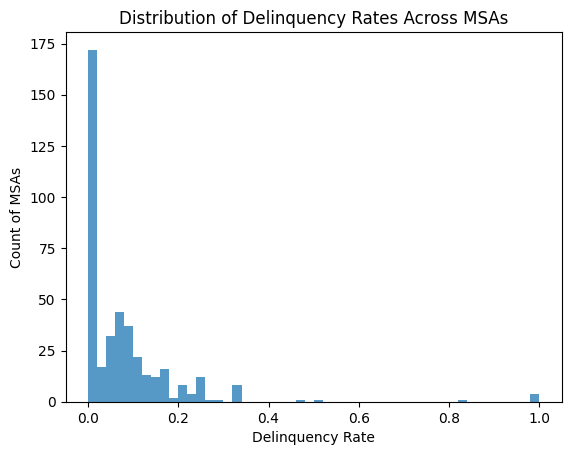

In [108]:
import matplotlib.pyplot as plt

# plots
plt.hist(delinquency_rate_per_msa.values, bins=50, alpha=0.75)
plt.xlabel('Delinquency Rate')
plt.ylabel('Count of MSAs')
plt.title('Distribution of Delinquency Rates Across MSAs')
plt.show()

**COMMENTS**

According to the results in the histogram, the distribution of delinquency rates across different Metropolitan Statistical Areas is not evenly spread across all MSAs, and certain MSAs may have higher delinquency rates than others. It appears that a large number of MSAs have low delinquency rates, with a steep drop-off as the rate increases, indicating that most MSAs have a delinquency rate that is quite low.

In [109]:
"""of course we should search for the missing data overall"""
missing_data = final_dataset.isna().sum()
missing_data = missing_data[missing_data > 0]
missing_data

msa                  4816
super_conforming    17471
prr_loan_seq_num    17471
rr_indicator        17471
dtype: int64

**COMMENTS**

So based on the results above, clearly we can get rid of at least `msa`, `super_conforming`, `prr_loan_seq_num`, `rr_indicator` columns.

### Exercise 9

For your analysis, include the following variables: 

```
Credit Score
First Time Homebuyer Flag
Number of Units
Mortgage Insurance Percentage (MI %)
Occupancy Status
Original Debt-to-Income (DTI) Ratio
Original UPB
Original Loan-to-Value (LTV)
Original Interest Rate
Channel
Prepayment Penalty Mortgage (PPM) Flag
Amortization Type (Formerly Product Type)
Property State
Property Type
Original Loan Term
Number of Borrowers
Interest Only (I/O) Indicator
```

Be sure to clean these variables. When doing so, please treat missing data as missing (e.g., `np.nan`, not as a distinct category).

In [110]:
# here we again subset including the variables mentioned above 
## + 2 columns with loan sequence number and delinquency indicator
narrow_columns = ['credit_score', 'first_time_buyer', 'num_of_units', 'mi_percent', 'occupancy_status', 
                  'original_dti_ratio', 'original_upb', 'original_ltv', 'original_interest_rt', 'channel', 
                  'ppm_flag', 'amortization_type', 'property_state', 'property_type', 'original_loan_term', 
                  'num_borrowers', 'io_indicator', 'loan_seq_num', 'delinq_index']

narrow_dataset = final_dataset[narrow_columns]
narrow_dataset

,credit_score,first_time_buyer,num_of_units,mi_percent,occupancy_status,original_dti_ratio,original_upb,original_ltv,original_interest_rt,channel,ppm_flag,amortization_type,property_state,property_type,original_loan_term,num_borrowers,io_indicator,loan_seq_num,delinq_index
71,653,Y,1,17,P,25,127000,87,6.050,R,N,FRM,WI,SF,360,2,N,F04Q10000054,0
106,747,N,2,0,I,34,121000,70,6.125,R,N,FRM,NE,PU,360,1,N,F04Q10000200,0
141,731,N,1,0,P,40,286000,80,5.125,T,N,FRM,IL,PU,180,2,N,F04Q10000236,0
281,682,N,1,0,P,30,114000,80,5.500,R,N,FRM,IN,SF,180,2,N,F04Q10000281,0
316,730,N,1,0,P,30,132000,80,5.750,R,N,FRM,CO,SF,360,1,N,F04Q10000296,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1287115,790,N,1,0,S,30,34000,80,6.625,R,N,FRM,WV,CO,180,2,N,F04Q40400028,0
1287119,609,N,1,0,P,21,283000,74,6.000,R,N,FRM,FL,PU,360,2,N,F04Q40400034,0
1287127,805,N,1,12,P,33,225000,85,6.375,R,N,FRM,OH,CO,360,1,N,F04Q40400050,0
1287131,736,N,1,0,S,7,350000,56,5.625,R,N,FRM,FL,PU,180,2,N,F04Q40400054,0


In [111]:
# get to know the narrow dataset better
print(narrow_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 17471 entries, 71 to 1287159
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   credit_score          17471 non-null  int64  
 1   first_time_buyer      17471 non-null  object 
 2   num_of_units          17471 non-null  int64  
 3   mi_percent            17471 non-null  int64  
 4   occupancy_status      17471 non-null  object 
 5   original_dti_ratio    17471 non-null  int64  
 6   original_upb          17471 non-null  int64  
 7   original_ltv          17471 non-null  int64  
 8   original_interest_rt  17471 non-null  float64
 9   channel               17471 non-null  object 
 10  ppm_flag              17471 non-null  object 
 11  amortization_type     17471 non-null  object 
 12  property_state        17471 non-null  object 
 13  property_type         17471 non-null  object 
 14  original_loan_term    17471 non-null  int64  
 15  num_borrowers        

**Below you can see a long but special cleaning treatment to each variable**

In [112]:
import numpy as np 

narrow_dataset['credit_score'] = narrow_dataset['credit_score'].replace(9999, np.nan)

In [113]:
narrow_dataset['first_time_buyer'] = narrow_dataset['first_time_buyer'].replace('9', np.nan)

In [114]:
narrow_dataset['num_of_units'] = narrow_dataset['num_of_units'].replace(99, np.nan)

In [115]:
narrow_dataset['mi_percent'] = narrow_dataset['mi_percent'].replace(999, np.nan)

In [116]:
print(narrow_dataset['occupancy_status'].unique())

['P' 'I' 'S']


In [117]:
narrow_dataset['original_dti_ratio'] = narrow_dataset['original_dti_ratio'].replace(999, np.nan)

In [118]:
print(narrow_dataset['original_ltv'].unique())
print(narrow_dataset['original_ltv'].nunique())

[ 87  70  80  24  73  72  51  56  90 100  53  75  68  97  66  59  37  95
  77  60  74  94  55  64  85  52  57  50  78  58  79  69  31  76  35  47
  92  88  41  62  71  48  39  63  67  89  44  65  93  54  86  25  36  91
  34  26  22  29  49  40  46  20  43  11  61  42  30  83  32  82  38  28
  27  18  33  16  45  15  84  21  14  19  99  96  13   9  98  23  10  12
  17  81   6]
93


In [119]:
narrow_dataset['property_type'] = narrow_dataset['property_type'].replace('99', np.nan)

In [120]:
narrow_dataset['num_borrowers'] = narrow_dataset['num_borrowers'].replace(99, np.nan)

In [121]:
print(narrow_dataset['io_indicator'].unique())

['N']


In [122]:
print(narrow_dataset['io_indicator'].unique())

['N']


In [123]:
print(narrow_dataset.isna().sum())

credit_score             40
first_time_buyer          7
num_of_units              3
mi_percent                2
occupancy_status          0
original_dti_ratio      363
original_upb              0
original_ltv              0
original_interest_rt      0
channel                   0
ppm_flag                  0
amortization_type         0
property_state            0
property_type             5
original_loan_term        0
num_borrowers             7
io_indicator              0
loan_seq_num              0
delinq_index              0
dtype: int64


### Exercise 10

The next step in our analysis is to convert our categorical variables to one-hot-encodings and use `train_test_split` to split our data.

To ensure replicability, **before** you `train_test_split` your data, please sort your data by `Loan Sequence Number`. This will ensure when we split the data with a random seed below, everyone will get the same split and the autograder will function.

You may create your one-hot-encodings however you wish, but I'm a fan of the [patsy library's](https://patsy.readthedocs.io/en/latest/overview.html) `dmatrices` function.

Hint: You should end up with 8 categorical variables, including some binary flags and `Number_of_Borrowers`, `Number_of_Units` (which you could argue should be continuous, but I think are better treated as categorical).

Store the number of observations in your final dataset in `ex10_num_obs`.

In [124]:
# Step 1. To ensure the replicability, before we split data into train 
## and test datasets, let's sort our data by Loan Sequence Number

narrow_dataset_sorted = narrow_dataset.sort_values(by="loan_seq_num")

In [128]:
import patsy as patsy
from patsy import dmatrices

# Step 2. usage of dmatrices
formula_parts = (
    "delinq_index ~ "
    "C(first_time_buyer) + "
    "C(num_of_units) + "
    "C(occupancy_status) + "
    "C(channel) + "
    "C(ppm_flag) + "
    "C(amortization_type) + "
    "C(property_state) + "
    "C(property_type) + "
    "C(num_borrowers) + "
    "C(io_indicator) + "
    "credit_score + "
    "mi_percent + "
    "original_dti_ratio + "
    "original_upb + "
    "original_ltv + "
    "original_interest_rt + "
    "original_loan_term"
)

y, X = patsy.dmatrices(formula_parts, data=narrow_dataset_sorted, return_type="dataframe")

ex10_num_obs = y.shape[0]
results["ex10_num_obs"] = ex10_num_obs

In [129]:
print(f'The number of observations in our final dataset is {ex10_num_obs}')

The number of observations in our final dataset is 17052


### Exercise 11

Use `train_test_split` from `sklearn.model_selection` to split the data. 

Before you do, Use `0.2` as the `test_size` and use `random_state=42`.

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Exercise 12

Now fit a `GradientBoostingClassifier` to the data (from `sklearn.ensemble`). Set `random_state=42`. using `roc_auc_score`, get your ROC AUC score against the test data. Store in `results` under the key `"ex12_roc_auc"`.

In [132]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

gradiend_boosting = GradientBoostingClassifier(random_state=42)
gradiend_boosting.fit(X_train, y_train)

y_pred_proba = gradiend_boosting.predict_proba(X_test)[:, 1]
roc_auc_sc = roc_auc_score(y_test, y_pred_proba)

results["ex12_roc_auc"] = roc_auc_sc

### Exercise 13

Use the `predict` method to generate a confusion matrix. What problem do you see with the result?

In [134]:
from sklearn.metrics import confusion_matrix

y_predict = gradiend_boosting.predict(X_test)

"""Confusion Matrix"""
confusion_matrix = confusion_matrix(y_test, y_predict)

df_c_matrix = pd.DataFrame(confusion_matrix, index=["Actual non-delinquent", "Actual delinquent"], columns=["Predicted non-delinquent", "Predicted delinquent"])
df_c_matrix

,Predicted non-delinquent,Predicted delinquent
Actual non-delinquent,3146,9
Actual delinquent,252,4


### Exercise 14

To address the problem from Exercise 13, use `.predict_proba()` to set your own threshold for classification. Your stakeholder is mostly concerned with False Negatives (mortgages classified as safe that actually are not), so use a 8% probability threshold to get a good balance of a low False Negative rate with a reasonable amount of mortgages still being considered "viable."

What is the False Negative rate at an 8% classification threshold from the model above?

Store the result under the key `"ex14_false_negative_rate"`.

### Exercise 15

Your stakeholder wants to by as many mortgages as it can while maintaining a delinquency rate of purchased mortgages below 5%. Based on your answer above, do you feel like your model can provide that level of performance?

## Now To The Future

The preceding analysis is precisely the type of analysis you would do if, in late 2006, you'd been asked to evaluate mortgage performance in the last two years for use going forward. So let's see how your model performs now!

In this [folder](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2007) you will find data on mortgages originated in 2007 along with servicing data from 2007, 2008, and 2009.

### Exercise 16

Please load this data (again, from a URL to help the autograder) and clean it in the same manner as before. As a sanity check, how many observations do you have in the final dataset (after you've removed observations with missing values to allow you to generate predicted delinquency rates)? 

Store the final number of observations in `"ex16_num_obs"` and the share of those mortgages that are delinquent in `"ex16_share_delinquent"`


### Exercise 17




Had your stakeholder purchased mortgages using your model, what would the resulting False Negative rate have been? (e.g., compare the predicted values for mortgages using the model trained above with realized outcomes). Store your result under the key `"ex17_false_negative_rate"`


### Exercise 18

How did the retrospective performance of your model compare to its actual performance moving forward? Why? Did you stay below the 5% target for False Negatives set by the stakeholder?